In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook
from scipy.linalg import svd
import catboost

%matplotlib inline

## Понимание данных

In [2]:
path_transactions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\transactions.csv"
path_clients = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\clients.csv"
path_categories = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\categories.csv"

### clients

In [3]:
clients = pd.read_csv(path_clients)
clients.head()

,id,fullname,address,phone_number,email,workplace,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,Волкова Фаина Афанасьевна,"с. Новосибирск, наб. Привокзальная, д. 58 к. 5...",8 (475) 014-6494,wkirillov@rambler.ru,"ст. Кировск (Мурм.), ш. Коммуны, д. 238 стр. 3...",1966-09-07,2017-01-10,F,230910.0,61975,1.0,NaN
1,2,Пелагея Вячеславовна Галкина,"клх Белокуриха, ш. Комсомольское, д. 701 стр. ...",+7 (981) 576-1146,bogdanovmoke@rambler.ru,"г. Елабуга, бул. 60 лет Октября, д. 5, 070955",1987-05-23,2016-07-14,F,NaN,75232,NaN,NaN
2,3,Валентина Игоревна Фомина,"к. Усть-Катав, бул. Восточный, д. 292 стр. 3, ...",+7 (920) 068-58-36,mjasnikovvalentin@mail.ru,"г. Сосновый Бор, алл. Лесхозная, д. 146, 139446",1974-06-15,2017-10-18,F,NaN,88813,NaN,NaN
3,4,тов. Воронцова Фёкла Федоровна,"клх Новая Игирма, алл. Пограничная, д. 6/6, 73...",8 334 398 3828,martin85@rambler.ru,"клх Котельнич, бул. Серафимовича, д. 97, 753076",1979-10-19,2012-08-25,F,NaN,55167,NaN,NaN
4,5,Филипп Дмитриевич Воронцов,"к. Ребриха, пр. Свободы, д. 54, 466509",8 (296) 455-0453,jan_07@rambler.ru,"клх Карабудахкент, ул. Абрикосовая, д. 3 к. 19...",1986-08-14,2017-03-15,M,NaN,85106,NaN,NaN


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
id                   1000 non-null int64
fullname             1000 non-null object
address              1000 non-null object
phone_number         1000 non-null object
email                1000 non-null object
workplace            1000 non-null object
birthdate            1000 non-null object
registration_date    1000 non-null object
gender               1000 non-null object
income               364 non-null float64
expenses             1000 non-null int64
credit               364 non-null float64
deposit              376 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 101.7+ KB


In [5]:
clients.id = clients.id.astype('str')

#### income

Заполним пропуски в данном столбце средним значением для тех клиентов, у которых не удалось определить значение среднего месячного дохода за последний год.

In [6]:
mean = clients.loc[clients['income'].isnull() != True, 'income'].mean()
clients.loc[clients['income'].isnull() == True, 'income'] = mean

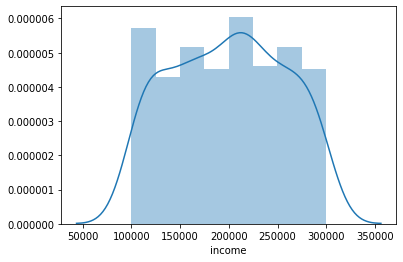

In [7]:
sns.distplot(clients.query('income != @mean')['income']); # уберем пользователей, у которых изначально отсутствовало значение income

#### credit

Заполним пропуски в данном столбце 0, что говорит о том, что клиент не брал кредит в банке.

In [8]:
clients.loc[clients['credit'].isnull() == True, 'credit'] = 0
clients.credit = clients.credit.astype('int')

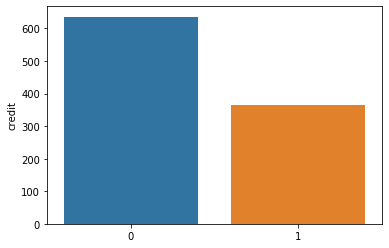

In [9]:
sns.barplot(x=clients.credit.value_counts().index, y=clients.credit.value_counts());

#### deposit

Заполним пропуски в данном столбце 0, что говорит о том, что клиент не брал депозит в банке.

In [10]:
clients.loc[clients['deposit'].isnull() == True, 'deposit'] = 0
clients.deposit = clients.deposit.astype('int')

In [11]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
id                   1000 non-null object
fullname             1000 non-null object
address              1000 non-null object
phone_number         1000 non-null object
email                1000 non-null object
workplace            1000 non-null object
birthdate            1000 non-null object
registration_date    1000 non-null object
gender               1000 non-null object
income               1000 non-null float64
expenses             1000 non-null int64
credit               1000 non-null int32
deposit              1000 non-null int32
dtypes: float64(1), int32(2), int64(1), object(9)
memory usage: 93.9+ KB


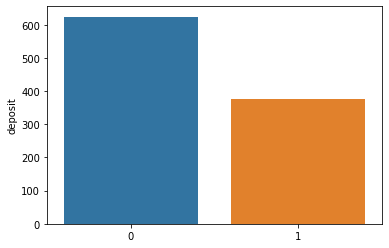

In [12]:
sns.barplot(x=clients.deposit.value_counts().index, y=clients.deposit.value_counts());

### categories

In [13]:
categories = pd.read_csv(path_categories)
categories

,id,name,description,mcc-code
0,1,Каршеринг,Краткосрочная аренда авто с оплатой по минутам...,"7512, 4121"
1,2,Супермаркеты,Покупки в супермаркетах и продуктовых магазинах,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,3,Такси,Услуги такси (каршеринг не входит в данную кат...,4121
3,4,Музыка,Покупки в магазинах музыки и музыкальных инстр...,"5733, 5735"
4,5,Фастфуд,Покупки в ресторанах быстрого питания,5814
5,6,Транспорт,Оплата городского и пригородного транспорта. В...,"4111, 4121, 4131, 4457, 4468, 4784, 4789, 5013..."
6,7,Аптеки,Покупки в аптеках,"5122, 5292, 5295, 5912"
7,8,Кино,Покупки в кинотеатрах и магазинах кино,"7829, 7832, 7841"
8,9,Книги,Покупки в книжных магазинах и газетных киосках,"2741, 5111, 5192, 5942, 5994"
9,10,Развлечения,"Оплата развлечений, (например, в магазинах вид...","7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992..."


In [14]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 4 columns):
id             29 non-null int64
name           29 non-null object
description    29 non-null object
mcc-code       27 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [15]:
categories.id = categories.id.astype('str')
categories['mcc-code'] = categories['mcc-code'].fillna('no_code')
categories['mcc-code'] = categories['mcc-code'].astype('str')
categories = categories.rename(columns={'id': 'product_category'})

### transactions

In [16]:
transactions = pd.read_csv(path_transactions)
transactions.head()

,Unnamed: 0,client_id,product_category,product_company,subtype,amount,date,transaction_type
0,34478,37,29,NaN,Автоплатеж,1209,2020-01-01 00:00:00,Negative
1,65406,71,4,YouTube Music,Подписка,169,2020-01-01 00:00:00,Negative
2,82186,88,29,NaN,Автоплатеж,3711,2020-01-01 00:00:00,Negative
3,83113,89,29,NaN,Автоплатеж,6443,2020-01-01 00:00:00,Negative
4,131373,141,29,NaN,Автоплатеж,7319,2020-01-01 00:00:00,Negative


In [17]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929135 entries, 0 to 929134
Data columns (total 8 columns):
Unnamed: 0          929135 non-null int64
client_id           929135 non-null int64
product_category    929135 non-null int64
product_company     644651 non-null object
subtype             929135 non-null object
amount              929135 non-null int64
date                929135 non-null object
transaction_type    929135 non-null object
dtypes: int64(4), object(4)
memory usage: 56.7+ MB


In [18]:
transactions.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
transactions.product_category = transactions.product_category.astype('str')
transactions.client_id = transactions.client_id.astype('str')
transactions.id = transactions.id.astype('str')
transactions.date = pd.to_datetime(transactions.date, format='%Y-%m-%d %H:%M:%S')
transactions.dtypes

id                          object
client_id                   object
product_category            object
product_company             object
subtype                     object
amount                       int64
date                datetime64[ns]
transaction_type            object
dtype: object

#### transaction_type

В нашем анализе для построения рекомендательной системы нужны те транзакции клиентов, которые говорят о том, что они приобрели ту или иную категорию товара или услуги, а не получили денежный перевод от кого-либо, поэтому уберем все транзакции, которые имеют transaction_type, равный Positive.

In [19]:
transactions.transaction_type.unique()

array(['Negative', 'Positive'], dtype=object)

In [20]:
transactions = transactions.query('transaction_type != "Positive"')

In [21]:
transactions.shape

(884151, 8)

#### product_category

Проанализировав имеющиеся категории товаров и услуг заметим, что категория 28 - Переводы (переводы, пополнения). Уберем все транзакции, в которых содержится данная категория, так как данную категорию нельзя связвать со спецификой решаемой задачи.

In [22]:
transactions = transactions.query('product_category != "28"')

In [23]:
transactions.shape

(839117, 8)

In [24]:
transactions.reset_index(inplace=True, drop=True)

In [25]:
transactions.product_category.value_counts()

6     350044
5     130137
2      45010
3      29839
1      29563
8      24225
9      24208
11     24087
14     24035
10     24007
7      23924
13     23877
15     16973
17      9191
20      9160
21      9154
16      9122
18      9108
19      9068
4       8004
29      5186
12       427
26       142
27       136
22       134
24       126
25       122
23       108
Name: product_category, dtype: int64

#### subtype

In [26]:
transactions.subtype.value_counts()

Покупка       825927
Подписка        8004
Автоплатеж      5186
Name: subtype, dtype: int64

#### product_company

In [27]:
transactions.product_company.value_counts()

Московский Метрополитен    116903
Стрелка                    116124
Тануки                      16513
PizzaHut                    16362
Burger King                 16275
                            ...  
Boom                         1395
Яндекс.Музыка                1370
YouTube Music                1352
Spotify                      1184
Apple Music                  1131
Name: product_company, Length: 68, dtype: int64

#### amount

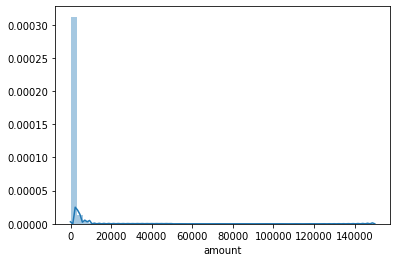

In [28]:
sns.distplot(transactions.amount);

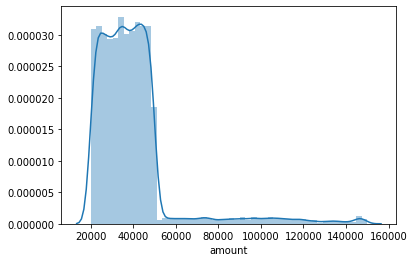

In [29]:
sns.distplot(transactions.query('amount > 20000')['amount']);

In [30]:
transactions_part = transactions[['client_id', 'product_category', 'date']]
transactions_part.head()

,client_id,product_category,date
0,37,29,2020-01-01
1,71,4,2020-01-01
2,88,29,2020-01-01
3,89,29,2020-01-01
4,141,29,2020-01-01


## Подготовка данных

### "Схлопывание" повторяющихся действий пользователей

Для каждого пользователя посчитаем количество того, сколько раз он взаимодействовал с каждой категорией товара в данных транзакций.

In [31]:
data = transactions_part.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'date': 'count'}) \
    .rename(columns={'date': 'purchase_count'})

In [32]:
data.head()

,client_id,product_category,purchase_count
0,1,10,18
1,1,11,14
2,1,13,23
3,1,14,19
4,1,16,10


### Фильтрация неактивных пользователей

Отфильтруем пользователей, которые взаимодействовали не больше, чем с 4 категориями товаров и услуг.

In [33]:
users_interactions = data \
    .groupby('client_id', as_index=False) \
    .agg({'product_category': 'count'}) \
    .rename(columns={'product_category': 'unique_categories'})
users_interactions.head()

,client_id,unique_categories
0,1,17
1,10,19
2,100,21
3,1000,21
4,101,20


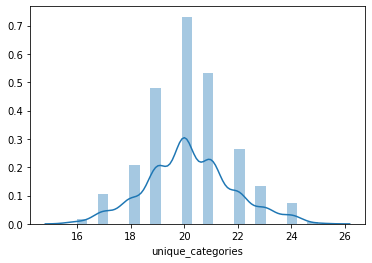

In [34]:
sns.distplot(users_interactions.unique_categories);

In [35]:
users_with_enough_interactions = users_interactions.query('unique_categories > 4')['client_id']
users_with_enough_interactions

0         1
1        10
2       100
3      1000
4       101
       ... 
995     995
996     996
997     997
998     998
999     999
Name: client_id, Length: 1000, dtype: object

In [36]:
print(f'Всего пользователей: {users_interactions.shape[0]}')
print(f'Пользователей по крайней мере с 5 взаимодействиями: {users_with_enough_interactions.shape[0]}')

Всего пользователей: 1000
Пользователей по крайней мере с 5 взаимодействиями: 1000


Получаем, что пользователей меньше, чем с 5 взаимодействиями нет.

### Масштабирование данных

В качестве масштабирования данных воспользуемся MinMaxScaler.

In [37]:
data = data.assign(purchase_normalize = (data.purchase_count - data.purchase_count.min()) / (data.purchase_count.max() - data.purchase_count.min()))
data.drop(columns=['purchase_count'])
data.head()

,client_id,product_category,purchase_count,purchase_normalize
0,1,10,18,0.042607
1,1,11,14,0.032581
2,1,13,23,0.055138
3,1,14,19,0.045113
4,1,16,10,0.022556


### Разбиение выборки на тренировочную и тестовую

Произведем разбиение выборки на обучение и контроль по времени. Перед этим возьмем последнее время взаимодействия пары client_id и product_category.

In [38]:
transactions_last_date = transactions_part \
    .groupby(['client_id', 'product_category'], as_index=False) \
    .date \
    .last()
transactions_last_date.head()

,client_id,product_category,date
0,1,10,2020-12-22 02:33:13
1,1,11,2020-12-22 10:20:44
2,1,13,2020-12-29 09:07:06
3,1,14,2020-12-31 06:49:11
4,1,16,2020-12-29 03:38:07


In [39]:
data = data \
    .merge(transactions_last_date, on=['client_id', 'product_category']) \
    .rename(columns={'date': 'last_date'})
data.head()

,client_id,product_category,purchase_count,purchase_normalize,last_date
0,1,10,18,0.042607,2020-12-22 02:33:13
1,1,11,14,0.032581,2020-12-22 10:20:44
2,1,13,23,0.055138,2020-12-29 09:07:06
3,1,14,19,0.045113,2020-12-31 06:49:11
4,1,16,10,0.022556,2020-12-29 03:38:07


In [40]:
split_date = '2020-12-30'
data_train = data.query('last_date < @split_date').copy()
data_test = data.query('last_date >= @split_date').copy()

print(f'Всего взаимодействий: {data.shape[0]}')
print(f'Доля взаимодействий в тренировочной выборке: {round(data_train.shape[0] / data.shape[0], 1)} ({data_train.shape[0]})')
print(f'Доля взаимодействий в тестовой выборке: {round(data_test.shape[0] / data.shape[0], 1)} ({data_test.shape[0]})')

Всего взаимодействий: 20201
Доля взаимодействий в тренировочной выборке: 0.8 (17051)
Доля взаимодействий в тестовой выборке: 0.2 (3150)


Для удобства подсчета качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [41]:
data_true = (
    data_train
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_category': 'true_train'})
    .set_index('client_id')
)

data_true['true_test'] = (
    data_test
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
)

Заполним пропуски пустыми списками.

In [42]:
data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
    list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

In [43]:
data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 5, 9]"


## Моделирование и оценка

Для каждого пользователя будем предсказывать только одну категорию товара или услуги в связи тем, что реклама только одной категории товара или услуги может быть показана пользователю в приложении.

### Метрики качества

В качестве метрик качества моделей рассчитаем следующие:
- precision@k;
- recall@k;
- F-score@k.

За основную метрику возьмем F-score@k.

In [44]:
top_k = 1 # количество категорий, которое нужно предсказать пользователю

In [45]:
def calc_precision(column):
    return (
        data_true
            .apply(
                lambda row: len(set(row['true_test']).intersection(row[column])) / min(len(row['true_test']) + 0.001, top_k),
                axis=1
            )
    ).mean()

In [46]:
def calc_recall(column):
    return (
        data_true
            .apply(
                lambda row: len(set(row['true_test']).intersection(row[column])) / min(len(row[column]) + 0.001, top_k),
                axis=1
            )
    ).mean()

При прогнозировании нам важнее то, чтобы модель рекомендательной системы не рекомендовала пользователям то, что им не интересно, поэтому строя и оценивая наши модели, будем использовать измененную метрику качества F-score, в которой дадим больший вес точности (precision@k).

In [47]:
def calc_fscore_precision(column):
    beta = 0.5
    precision = calc_precision(column)
    recall = calc_recall(column)
    fscore_precision = ((1 + beta ** 2) * precision * recall) / (beta ** 2 * precision + recall)
    return fscore_precision

### Модель по полуярности (baseline)

Посчитаем популярность каждой категории, как сумму всех количеств взаимодействия с ней, и отсортируем категории по их популярности.

In [48]:
popular_category = (
    data_train
    .groupby('product_category', as_index=False)
    .agg({'purchase_normalize': 'sum'})
    .rename(columns={'purchase_normalize': 'purchase_total'})
    .sort_values('purchase_total', ascending=False)
    .product_category.values
)
popular_category

array(['5', '6', '2', '3', '1', '7', '11', '8', '13', '10', '14', '9',
       '15', '17', '21', '20', '16', '18', '19', '4', '29', '12', '26',
       '27', '24', '25', '22', '23'], dtype=object)

In [49]:
print(f"Наиболее популярной категорией является: {categories.query('product_category == @popular_category[0]')['name'].values[0]}")
print(f"Наименее популярной категорией является: {categories.query('product_category == @popular_category[-1]')['name'].values[0]}")

Наиболее популярной категорией является: Фастфуд
Наименее популярной категорией является: Автоуслуги


Делаем предсказания для каждого пользователя.

Рекомендуем каждому пользователю те категории товаров и услуг, которые он приобретал и которые еще нет. В этом случае каждому пользователю предлагаем самую популярную категорию.

In [50]:
data_true['prediction_popular_without'] = np.resize(popular_category[:top_k], (data_true.shape[0], 1))

In [51]:
data_true.head()

,true_train,true_test,prediction_popular_without
client_id,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 5, 9]",5
10,"[1, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 26...","[2, 6]",5
100,"[1, 10, 12, 13, 14, 16, 17, 18, 19, 2, 20, 21,...","[11, 5, 6, 9]",5
1000,"[1, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29...","[10, 2, 6, 7]",5
101,"[1, 10, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21,...",[6],5


In [52]:
print(f'Precision@1: {calc_precision("prediction_popular_without")}')
print(f'Recall@1: {calc_recall("prediction_popular_without")}')
print(f'F-score@1: {calc_fscore_precision("prediction_popular_without")}')

Precision@1: 0.524
Recall@1: 0.524
F-score@1: 0.524


### Коллаборативная фильтрация

In [53]:
data_matrix = pd.pivot_table(data, index='client_id', columns='product_category', values='purchase_normalize', fill_value=0)
data_matrix.head()

product_category,1,10,11,12,13,14,15,16,17,18,...,26,27,29,3,4,5,6,7,8,9
client_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.042607,0.032581,0.0,0.055138,0.045113,0.000000,0.022556,0.012531,0.040100,...,0.0,0.0,0.000000,0.000000,0.027569,0.378446,0.974937,0.065163,0.060150,0.047619
10,0.102757,0.050125,0.065163,0.0,0.070175,0.050125,0.000000,0.015038,0.022556,0.030075,...,0.0,0.0,0.000000,0.082707,0.000000,0.273183,0.784461,0.050125,0.065163,0.047619
100,0.110276,0.030075,0.045113,0.0,0.030075,0.035088,0.000000,0.025063,0.035088,0.030075,...,0.0,0.0,0.022556,0.067669,0.020050,0.283208,0.781955,0.035088,0.047619,0.062657
1000,0.080201,0.075188,0.077694,0.0,0.057644,0.065163,0.117794,0.012531,0.010025,0.020050,...,0.0,0.0,0.027569,0.080201,0.027569,0.338346,0.979950,0.075188,0.072682,0.067669
101,0.067669,0.067669,0.082707,0.0,0.090226,0.057644,0.000000,0.020050,0.015038,0.022556,...,0.0,0.0,0.002506,0.110276,0.007519,0.338346,0.862155,0.077694,0.082707,0.057644


#### Memory-dased

In [54]:
matrix = data_matrix.values

In [55]:
similarity_users = np.zeros((len(matrix), len(matrix)))

for i in tqdm_notebook(range(len(matrix))):
    for j in range(i+1, len(matrix)):
        
        # nonzero elements of two users
        mask_uv = (matrix[i] != 0) & (matrix[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = matrix[i, mask_uv]
        ratings_u = matrix[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

In [56]:
prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(matrix[users_sim].sum(axis=0))[::-1]
        tmp_recommend = data_matrix.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[:top_k] #***
        prediction_user_based.append(list(recommend))

data_true['prediction_user_based'] = prediction_user_based

In [57]:
print(f'Precision@k: {calc_precision("prediction_user_based")}')
print(f'Recall@k: {calc_recall("prediction_user_based")}')
print(f'F-score@k: {calc_fscore_precision("prediction_user_based")}')

Precision@k: 0.855
Recall@k: 0.855
F-score@k: 0.855


#### Latent Factor Model

In [58]:
U, sigma, V = svd(data_matrix)
print(data_matrix.shape, U.shape, sigma.shape, V.shape)

(1000, 28) (1000, 1000) (28,) (28, 28)


In [59]:
Sigma = np.zeros((1000, 28))
Sigma[:28, :28] = np.diag(sigma)

new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))

9.617382236731986e-26


Значения у матрицы с сингулярными числами отсортированы по убыванию. Оставим только первые 25 компонент и получим скрытые представления размерности 25.

In [60]:
K = 25
sigma[K:] = 0
Sigma = np.zeros((1000, 28))
Sigma[:28, :28] = np.diag(sigma)

In [61]:
new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))
print(sum(sum((data_matrix.values.mean() - data_matrix.values) ** 2)))

0.00038219029302177923
786.2026227724698


In [62]:
new_data_matrix = pd.DataFrame(new_data_matrix, index=data_matrix.index, columns=data_matrix.columns)

predictions = []
for client_id in tqdm_notebook(data_true.index):
    prediction = (
        new_data_matrix
        .loc[client_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction)[:top_k]) #***

data_true['prediction_svd'] = predictions

In [63]:
print(f'Precision@k: {calc_precision("prediction_svd")}')
print(f'Recall@k: {calc_recall("prediction_svd")}')
print(f'F-score@k: {calc_fscore_precision("prediction_svd")}')

Precision@k: 0.855
Recall@k: 0.855
F-score@k: 0.855


### Контентная модель

In [44]:
test_client_id = np.repeat(data_true.index, len(data_matrix.columns)) 
test_product_category = list(data_matrix.columns) * len(data_true)
test = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])

data_train_content = pd.concat((
    data_train,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(data_train)]]), ignore_index=True)
data_train.purchase_normalize.fillna(0, inplace=True)

C:\Users\kiril\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [45]:
data_train_content = data_train_content.merge(categories, how='left', on='product_category')
data_test_content = data_test.merge(categories, how='left', on='product_category')

In [46]:
data_train_content.drop(columns=['name', 'description'], inplace=True)
data_test_content.drop(columns=['name', 'description'], inplace=True)

In [47]:
data_train_content.head()

,client_id,last_date,product_category,purchase_count,purchase_normalize,mcc-code
0,1,2020-12-22 02:33:13,10,18.0,0.042607,"7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992..."
1,1,2020-12-22 10:20:44,11,14.0,0.032581,"5977, 7230, 7297, 7298"
2,1,2020-12-29 09:07:06,13,23.0,0.055138,"5094, 5137, 5139, 5611, 5621, 5631, 5641, 5651..."
3,1,2020-12-29 03:38:07,16,10.0,0.022556,"5995, 0742"
4,1,2020-11-11 05:21:46,17,6.0,0.012531,"1520, 1711, 1731, 1740, 1750, 1761, 1771, 1799..."


In [48]:
data_test_content.head()

,client_id,product_category,purchase_count,purchase_normalize,last_date,mcc-code
0,1,14,19,0.045113,2020-12-31 06:49:11,"5811, 5812, 5813"
1,1,28,111,0.275689,2020-12-31 05:48:08,no_code
2,1,5,152,0.378446,2020-12-30 01:48:37,5814
3,1,9,20,0.047619,2020-12-30 23:54:16,"2741, 5111, 5192, 5942, 5994"
4,2,5,136,0.338346,2020-12-30 05:57:08,5814


In [49]:
features_start = len(data_train_content.columns) - 1
features_start

5

In [50]:
test_client_id = np.repeat(data_true.index, len(categories)) 
test_product_category = list(categories.product_category) * len(data_true)
test = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])
test = test.merge(categories, how='left', on='product_category')
test.drop(columns=['name', 'description'], inplace=True)

In [51]:
test.head()

,client_id,product_category,mcc-code
0,1,1,"7512, 4121"
1,1,2,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,1,3,4121
3,1,4,"5733, 5735"
4,1,5,5814


In [52]:
def mcc_count(column_value):
    if column_value == 'no_code':
        return 0
    else:
        mcc_count = len(column_value.split(', '))
        return mcc_count

In [53]:
data_train_content['mcc-code'] = data_train_content['mcc-code'].apply(mcc_count)
test['mcc-code'] = test['mcc-code'].apply(mcc_count)

In [54]:
X_train_content = data_train_content[data_train_content.columns[features_start:]]
y_train_content = np.array(data_train_content.purchase_normalize > 0, dtype=int)

In [55]:
model = catboost.CatBoostClassifier()
model.fit(X_train_content, y_train_content)

Learning rate set to 0.053158
0:	learn: 0.6862877	total: 199ms	remaining: 3m 18s
1:	learn: 0.6808951	total: 244ms	remaining: 2m 1s
2:	learn: 0.6753544	total: 277ms	remaining: 1m 31s
3:	learn: 0.6698093	total: 294ms	remaining: 1m 13s
4:	learn: 0.6649210	total: 309ms	remaining: 1m 1s
5:	learn: 0.6606872	total: 320ms	remaining: 53.1s
6:	learn: 0.6577370	total: 335ms	remaining: 47.5s
7:	learn: 0.6544662	total: 348ms	remaining: 43.2s
8:	learn: 0.6525464	total: 361ms	remaining: 39.7s
9:	learn: 0.6491402	total: 373ms	remaining: 36.9s
10:	learn: 0.6465558	total: 404ms	remaining: 36.3s
11:	learn: 0.6448588	total: 418ms	remaining: 34.4s
12:	learn: 0.6433300	total: 430ms	remaining: 32.6s
13:	learn: 0.6413223	total: 443ms	remaining: 31.2s
14:	learn: 0.6401957	total: 453ms	remaining: 29.7s
15:	learn: 0.6392524	total: 467ms	remaining: 28.7s
16:	learn: 0.6375654	total: 480ms	remaining: 27.8s
17:	learn: 0.6363658	total: 493ms	remaining: 26.9s
18:	learn: 0.6356793	total: 507ms	remaining: 26.2s
19:	lear

160:	learn: 0.6213509	total: 2.71s	remaining: 14.1s
161:	learn: 0.6213509	total: 2.72s	remaining: 14.1s
162:	learn: 0.6213492	total: 2.73s	remaining: 14s
163:	learn: 0.6213492	total: 2.76s	remaining: 14.1s
164:	learn: 0.6213491	total: 2.77s	remaining: 14s
165:	learn: 0.6213424	total: 2.79s	remaining: 14s
166:	learn: 0.6213407	total: 2.81s	remaining: 14s
167:	learn: 0.6213404	total: 2.82s	remaining: 14s
168:	learn: 0.6213379	total: 2.85s	remaining: 14s
169:	learn: 0.6213375	total: 2.86s	remaining: 14s
170:	learn: 0.6213347	total: 2.87s	remaining: 13.9s
171:	learn: 0.6213347	total: 2.88s	remaining: 13.9s
172:	learn: 0.6213267	total: 2.9s	remaining: 13.9s
173:	learn: 0.6213267	total: 2.92s	remaining: 13.9s
174:	learn: 0.6213267	total: 2.94s	remaining: 13.9s
175:	learn: 0.6213265	total: 2.95s	remaining: 13.8s
176:	learn: 0.6213259	total: 2.98s	remaining: 13.8s
177:	learn: 0.6213236	total: 2.99s	remaining: 13.8s
178:	learn: 0.6213235	total: 3s	remaining: 13.8s
179:	learn: 0.6213226	total: 3

319:	learn: 0.6212052	total: 5.13s	remaining: 10.9s
320:	learn: 0.6212047	total: 5.16s	remaining: 10.9s
321:	learn: 0.6212046	total: 5.17s	remaining: 10.9s
322:	learn: 0.6212040	total: 5.18s	remaining: 10.9s
323:	learn: 0.6212040	total: 5.2s	remaining: 10.8s
324:	learn: 0.6212039	total: 5.22s	remaining: 10.8s
325:	learn: 0.6212039	total: 5.23s	remaining: 10.8s
326:	learn: 0.6212039	total: 5.25s	remaining: 10.8s
327:	learn: 0.6212039	total: 5.27s	remaining: 10.8s
328:	learn: 0.6212038	total: 5.29s	remaining: 10.8s
329:	learn: 0.6212038	total: 5.3s	remaining: 10.8s
330:	learn: 0.6212038	total: 5.31s	remaining: 10.7s
331:	learn: 0.6212038	total: 5.34s	remaining: 10.7s
332:	learn: 0.6212032	total: 5.35s	remaining: 10.7s
333:	learn: 0.6212032	total: 5.36s	remaining: 10.7s
334:	learn: 0.6212032	total: 5.38s	remaining: 10.7s
335:	learn: 0.6212032	total: 5.39s	remaining: 10.6s
336:	learn: 0.6212027	total: 5.4s	remaining: 10.6s
337:	learn: 0.6212027	total: 5.41s	remaining: 10.6s
338:	learn: 0.6

478:	learn: 0.6211956	total: 7.67s	remaining: 8.34s
479:	learn: 0.6211956	total: 7.68s	remaining: 8.32s
480:	learn: 0.6211956	total: 7.7s	remaining: 8.3s
481:	learn: 0.6211956	total: 7.72s	remaining: 8.29s
482:	learn: 0.6211956	total: 7.73s	remaining: 8.28s
483:	learn: 0.6211956	total: 7.74s	remaining: 8.25s
484:	learn: 0.6211956	total: 7.76s	remaining: 8.24s
485:	learn: 0.6211956	total: 7.77s	remaining: 8.21s
486:	learn: 0.6211956	total: 7.78s	remaining: 8.2s
487:	learn: 0.6211955	total: 7.79s	remaining: 8.18s
488:	learn: 0.6211955	total: 7.81s	remaining: 8.16s
489:	learn: 0.6211955	total: 7.82s	remaining: 8.14s
490:	learn: 0.6211955	total: 7.83s	remaining: 8.12s
491:	learn: 0.6211955	total: 7.85s	remaining: 8.11s
492:	learn: 0.6211955	total: 7.86s	remaining: 8.08s
493:	learn: 0.6211955	total: 7.87s	remaining: 8.06s
494:	learn: 0.6211955	total: 7.88s	remaining: 8.04s
495:	learn: 0.6211955	total: 7.9s	remaining: 8.02s
496:	learn: 0.6211955	total: 7.91s	remaining: 8s
497:	learn: 0.62119

637:	learn: 0.6211942	total: 10s	remaining: 5.69s
638:	learn: 0.6211942	total: 10s	remaining: 5.67s
639:	learn: 0.6211942	total: 10s	remaining: 5.65s
640:	learn: 0.6211942	total: 10.1s	remaining: 5.64s
641:	learn: 0.6211942	total: 10.1s	remaining: 5.62s
642:	learn: 0.6211942	total: 10.1s	remaining: 5.61s
643:	learn: 0.6211942	total: 10.1s	remaining: 5.59s
644:	learn: 0.6211942	total: 10.1s	remaining: 5.58s
645:	learn: 0.6211942	total: 10.1s	remaining: 5.56s
646:	learn: 0.6211942	total: 10.2s	remaining: 5.54s
647:	learn: 0.6211942	total: 10.2s	remaining: 5.52s
648:	learn: 0.6211942	total: 10.2s	remaining: 5.51s
649:	learn: 0.6211942	total: 10.2s	remaining: 5.5s
650:	learn: 0.6211942	total: 10.2s	remaining: 5.48s
651:	learn: 0.6211942	total: 10.2s	remaining: 5.46s
652:	learn: 0.6211942	total: 10.2s	remaining: 5.44s
653:	learn: 0.6211942	total: 10.3s	remaining: 5.42s
654:	learn: 0.6211942	total: 10.3s	remaining: 5.41s
655:	learn: 0.6211942	total: 10.3s	remaining: 5.39s
656:	learn: 0.62119

796:	learn: 0.6211940	total: 12.5s	remaining: 3.19s
797:	learn: 0.6211940	total: 12.5s	remaining: 3.17s
798:	learn: 0.6211940	total: 12.6s	remaining: 3.16s
799:	learn: 0.6211940	total: 12.6s	remaining: 3.14s
800:	learn: 0.6211940	total: 12.6s	remaining: 3.13s
801:	learn: 0.6211940	total: 12.6s	remaining: 3.11s
802:	learn: 0.6211940	total: 12.6s	remaining: 3.1s
803:	learn: 0.6211940	total: 12.6s	remaining: 3.08s
804:	learn: 0.6211940	total: 12.6s	remaining: 3.06s
805:	learn: 0.6211940	total: 12.7s	remaining: 3.05s
806:	learn: 0.6211940	total: 12.7s	remaining: 3.03s
807:	learn: 0.6211940	total: 12.7s	remaining: 3.02s
808:	learn: 0.6211940	total: 12.7s	remaining: 3s
809:	learn: 0.6211940	total: 12.7s	remaining: 2.98s
810:	learn: 0.6211940	total: 12.7s	remaining: 2.97s
811:	learn: 0.6211940	total: 12.7s	remaining: 2.95s
812:	learn: 0.6211940	total: 12.8s	remaining: 2.94s
813:	learn: 0.6211940	total: 12.8s	remaining: 2.92s
814:	learn: 0.6211940	total: 12.8s	remaining: 2.9s
815:	learn: 0.621

955:	learn: 0.6211938	total: 15s	remaining: 689ms
956:	learn: 0.6211938	total: 15s	remaining: 674ms
957:	learn: 0.6211938	total: 15s	remaining: 658ms
958:	learn: 0.6211938	total: 15s	remaining: 642ms
959:	learn: 0.6211938	total: 15.1s	remaining: 627ms
960:	learn: 0.6211938	total: 15.1s	remaining: 611ms
961:	learn: 0.6211938	total: 15.1s	remaining: 596ms
962:	learn: 0.6211938	total: 15.1s	remaining: 580ms
963:	learn: 0.6211938	total: 15.1s	remaining: 564ms
964:	learn: 0.6211938	total: 15.1s	remaining: 548ms
965:	learn: 0.6211938	total: 15.1s	remaining: 532ms
966:	learn: 0.6211938	total: 15.1s	remaining: 517ms
967:	learn: 0.6211938	total: 15.1s	remaining: 501ms
968:	learn: 0.6211938	total: 15.2s	remaining: 485ms
969:	learn: 0.6211938	total: 15.2s	remaining: 470ms
970:	learn: 0.6211938	total: 15.2s	remaining: 454ms
971:	learn: 0.6211938	total: 15.2s	remaining: 439ms
972:	learn: 0.6211938	total: 15.2s	remaining: 423ms
973:	learn: 0.6211938	total: 15.3s	remaining: 407ms
974:	learn: 0.621193

In [56]:
predictions = model.predict_proba(test[data_train_content.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('client_id')['product_category'].agg(list)
tmp_predictions = []

for client_id in tqdm_notebook(data_true.index):
    prediction = np.array(predictions[client_id - 1])
    
    tmp_predictions.append(
        list(prediction)[:top_k]) #***
    
data_true['prediction_content'] = tmp_predictions

In [57]:
print(f'Precision@k: {calc_precision("prediction_content")}')
print(f'Recall@k: {calc_recall("prediction_content")}')
print(f'F-score@k: {calc_fscore_precision("prediction_content")}')

Precision@k: 0.045
Recall@k: 0.045
F-score@k: 0.045
